# Chapter 5 - Nonstationary Time Series Models

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from PythonTsa.datadir import getdtapath
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
from PythonTsa.plot_acf_pacf import acf_pacf_fig
from statsmodels.tsa.arima_process import arma_generate_sample
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import month_plot
from pmdarima import auto_arima
import itertools
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from PythonTsa.ModResidDiag import plot_ResidDiag

In [4]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

### Build an appropriate SARIMA model for the time series data in Example 5.1, and then diagnose the model.

In [6]:
dtapath=getdtapath()

# America Monthly Employment Figures for Females Aged 20 Years and Over
amef =pd.read_csv(dtapath + 'USFemalesAged20+Job1948-81.csv', header = None)
amef

,0
0,446
1,650
2,592
3,561
4,491
...,...
403,2975
404,3064
405,3092
406,3063


In [7]:
dates = pd.date_range(start='1948-01', periods = len(amef), freq='M')
amef.index =dates
amef=pd.Series(amef[0])

amef.head()

1948-01-31    446
1948-02-29    650
1948-03-31    592
1948-04-30    561
1948-05-31    491
Freq: ME, Name: 0, dtype: int64

In [8]:
amef.tail()

1981-08-31    2975
1981-09-30    3064
1981-10-31    3092
1981-11-30    3063
1981-12-31    2991
Freq: ME, Name: 0, dtype: int64

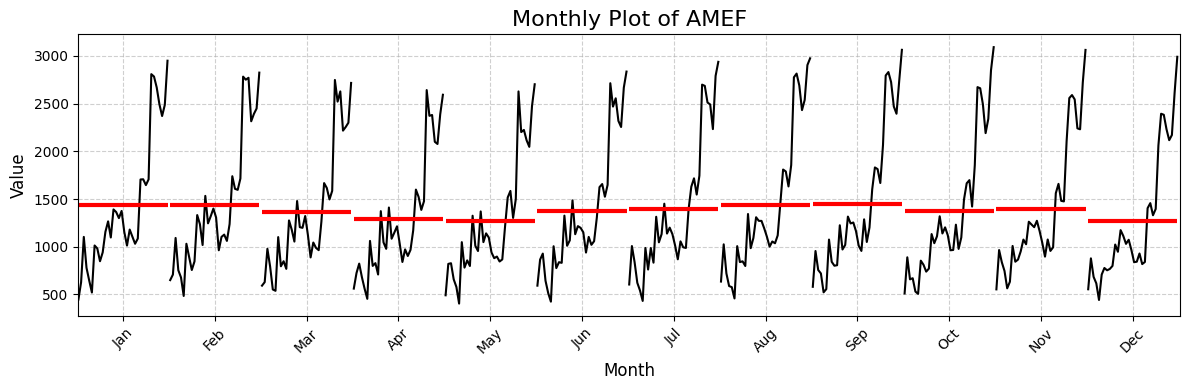

In [9]:
# Create the month plot
fig, ax = plt.subplots(figsize=(12, 4)) 

# from statsmodels.graphics.tsaplots import month_plot
month_plot(amef, ax=ax)

# Add a title
ax.set_title('Monthly Plot of AMEF', fontsize=16)

# Label the axes
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Value', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add gridlines for better clarity
ax.grid(True, linestyle='--', alpha=0.6)

# Set limits on the axes X
ax.set_xlim([0, len(amef)])

# Show the plot
plt.tight_layout()
plt.show()

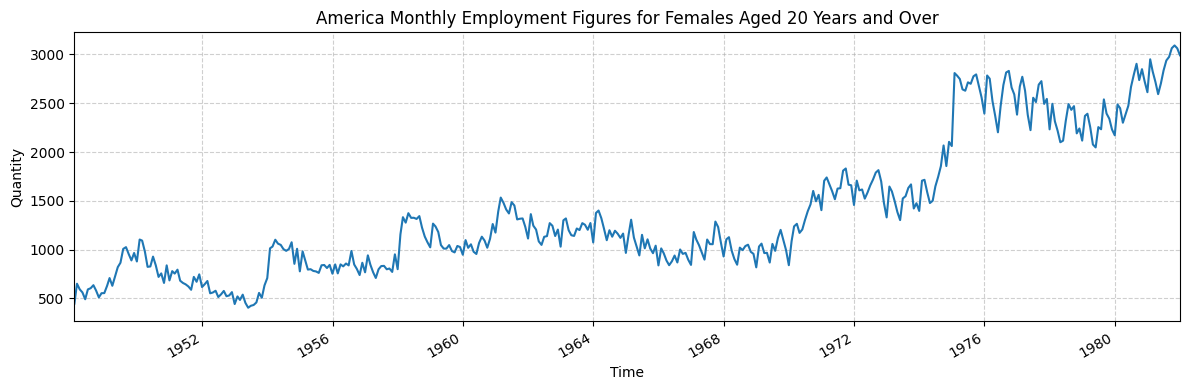

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(amef)
ax.set_xlabel('Time')
ax.set_ylabel('Quantity')
ax.set_title('America Monthly Employment Figures for Females Aged 20 Years and Over')
ax.set_xlim(pd.to_datetime('1948-01-31'), pd.to_datetime('1981-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  
ax.grid(axis='x', linestyle='--', alpha=0.6) 

fig.autofmt_xdate()
plt.tight_layout()

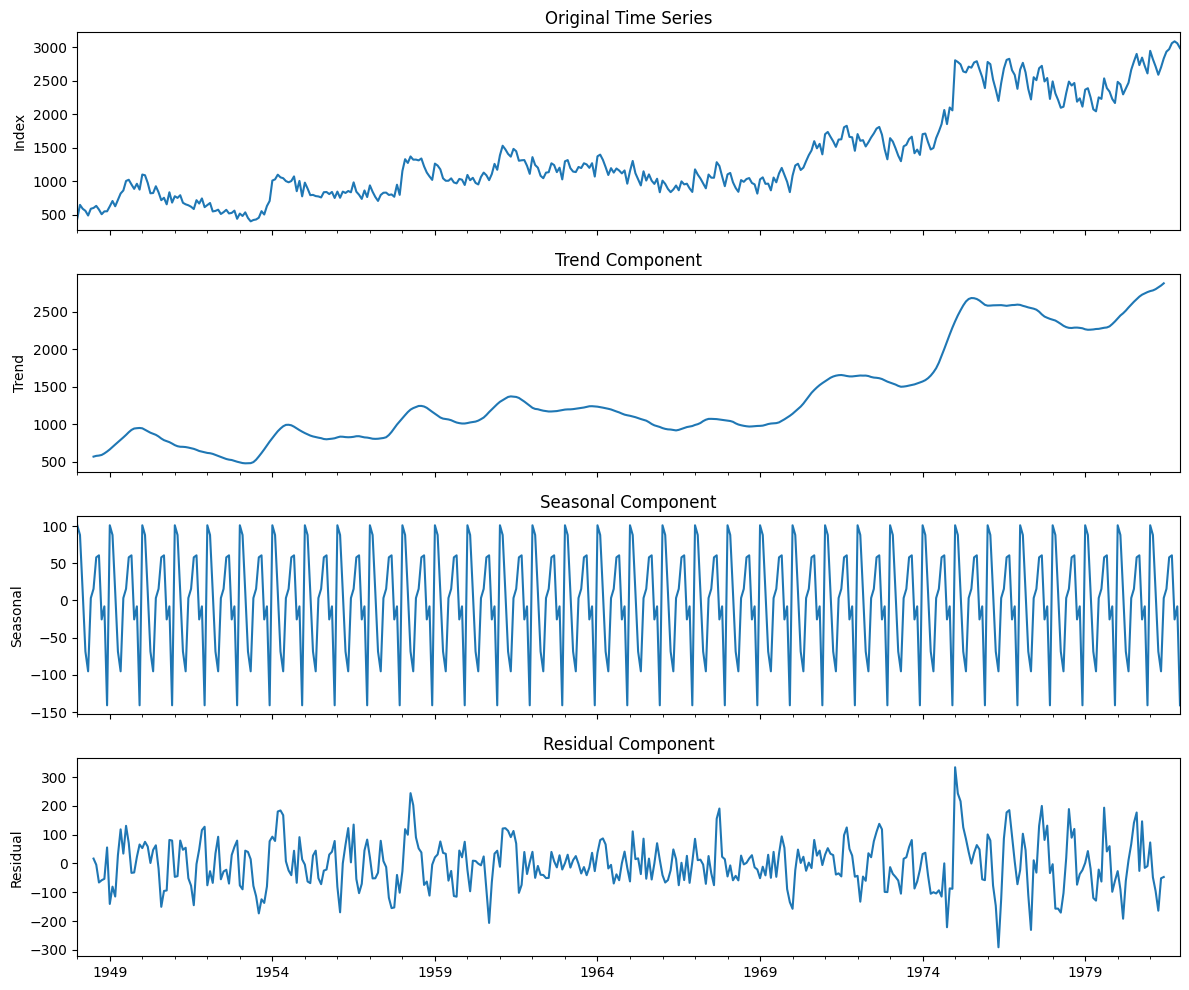

In [11]:
# Perform seasonal decomposition
amef_decom = seasonal_decompose(amef, model='aditive')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

amef_decom.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Index')

amef_decom.trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

amef_decom.seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

amef_decom.resid.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [12]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(amef_decom.trend.dropna())

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: 0.44506976804127507
      p-value: 0.9831043639766691

p-value > alpha; H0: Not Stationary


In [13]:
# First-Order differencing
eps_diff1 = np.diff(amef_decom.trend.dropna(), n=1)

ad_fuller_result1 = adfuller(eps_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -4.4706276320267815
p-value: 0.00022211915319359125

p-value < alpha; Ha: Stationary


    d = 1

In [15]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(amef_decom.seasonal.dropna())

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"      p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -352833060342228.44
      p-value: 0.0

p-value < alpha; Ha: Stationary


    D = 0

In [17]:
# Split the data into training and test sets (90% for training, 10% for testing)
train_size = int(len(amef) * 0.9)
train_data, test_data = amef[:train_size], amef[train_size:]

print(len(train_data))
print(len(test_data))

367
41


In [18]:
# Fit the auto_arima model (from pmdarima import auto_arima)
model_amef = auto_arima(train_data, seasonal=True, m=12, trace=True, stepwise=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4589.374, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4409.667, Time=0.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4481.419, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=4588.080, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4577.674, Time=0.06 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=4371.007, Time=2.46 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=4316.749, Time=4.42 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=4315.081, Time=1.31 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=4480.727, Time=0.45 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=4316.616, Time=4.62 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=4450.321, Time=1.50 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=4314.892, Time=0.75 sec
 ARIMA(0,1,0)(0,0,1)[12] inte

    Best model:  ARIMA(2,1,0)(1,0,1)[12]          

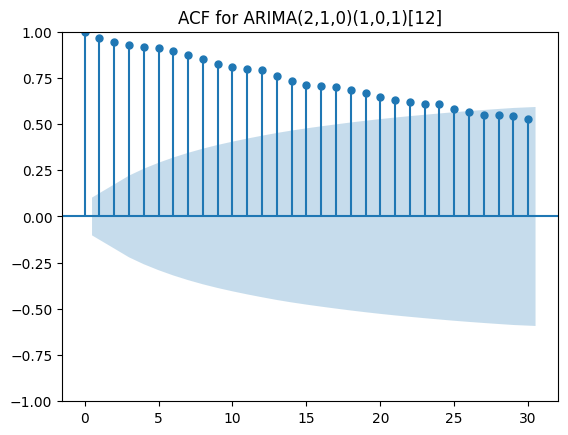

In [20]:
# Plot Auto Correlation Function
plot_acf(train_data, lags=30);

plt.title('ACF for ARIMA(2,1,0)(1,0,1)[12]')

plt.show()

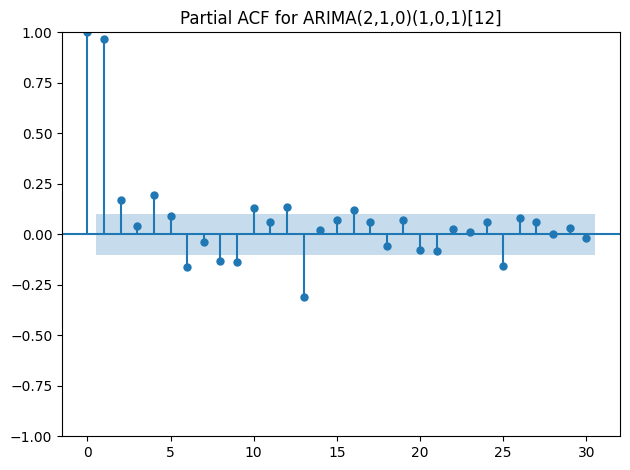

In [21]:
# Plot Partial Auto Correlation Function
plot_pacf(train_data, lags=30);

plt.title('Partial ACF for ARIMA(2,1,0)(1,0,1)[12]')

plt.tight_layout()

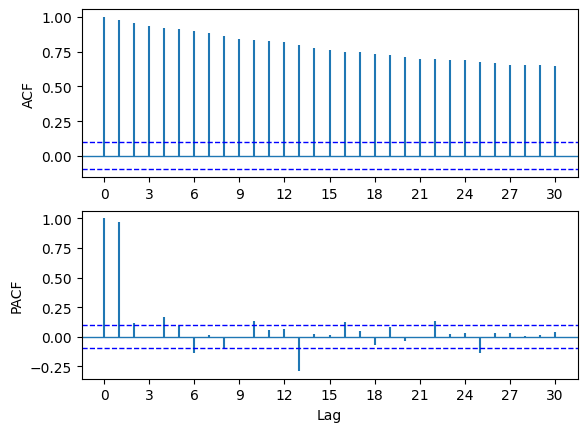

In [22]:
acf_pacf_fig(amef, both = True)

In [23]:
SARIMA_model_fit = sm.tsa.SARIMAX(train_data, order = (2,1,0), seasonal_order=(1,0,1,12)).fit()
SARIMA_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  367
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -2150.000
Date:                              Fri, 07 Mar 2025   AIC                           4310.000
Time:                                      14:14:05   BIC                           4329.513
Sample:                                  01-31-1948   HQIC                          4317.754
                                       - 07-31-1978                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0622      0.054     -1.162      0.245      -0.167       0.043
ar.L2          0.1199      0.042      2.833      0.005       0.037       0.203
ar.S.L12       0.9839      0.013     74.035      0.000       0.958       1.010
ma.S.L12      -0.7619      0.054    -14.162      0.000      -0.867      -0.656
sigma2      7047.4435    460.626     15.300      0.000    6144.632    7950.255
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               120.42
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                             0.74
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

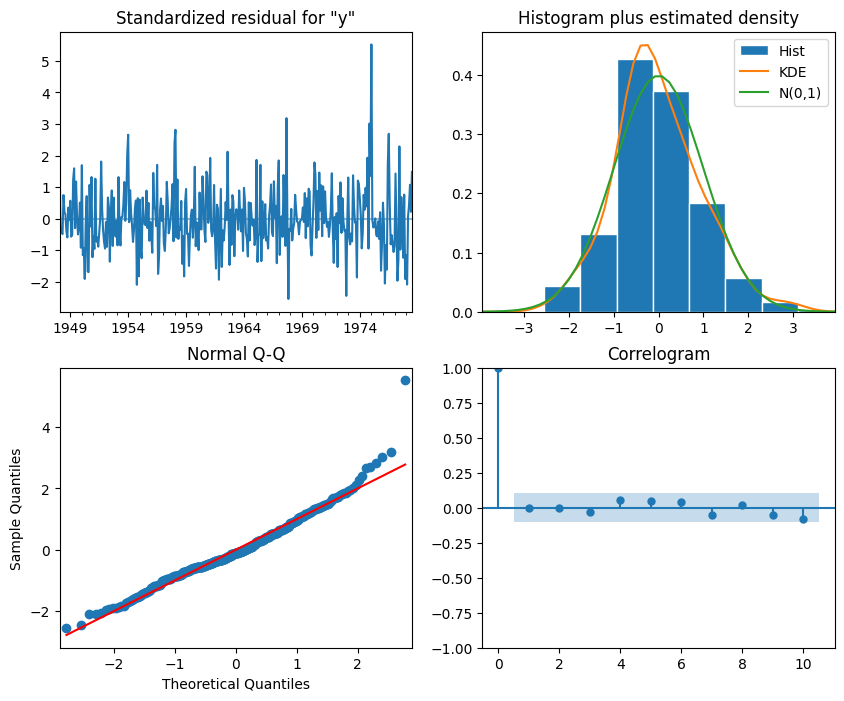

In [24]:
SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [25]:
# Extract the residuals (errors) from the fitted model
residuals = SARIMA_model_fit.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.249093,0.617715
2,0.325575,0.849772
3,1.125597,0.770899
4,1.776709,0.776741
5,3.257100,0.660416
6,4.126677,0.659538
7,5.091636,0.648781
8,5.096469,0.747217
9,6.503069,0.688702
10,7.814223,0.646978


In [26]:
# Create an empty dataframe
test_zone = pd.DataFrame()

# Original Data created based on the end of the original dataset
test_zone['original data'] = amef.iloc[-len(test_data):]

test_zone.head()

,original data
1978-08-31,2432
1978-09-30,2470
1978-10-31,2191
1978-11-30,2241
1978-12-31,2117


In [27]:
# Forecast for the  data (amef)
forecast_amef = SARIMA_model_fit.forecast(steps=len(test_data))

test_zone['forecast_amef'] = forecast_amef
test_zone['difference'] = test_zone['forecast_amef'] - test_zone['original data']

test_zone.head()

,original data,forecast_amef,difference
1978-08-31,2432,2594.066519,162.066519
1978-09-30,2470,2657.903505,187.903505
1978-10-31,2191,2497.233753,306.233753
1978-11-30,2241,2497.710503,256.710503
1978-12-31,2117,2324.183782,207.183782


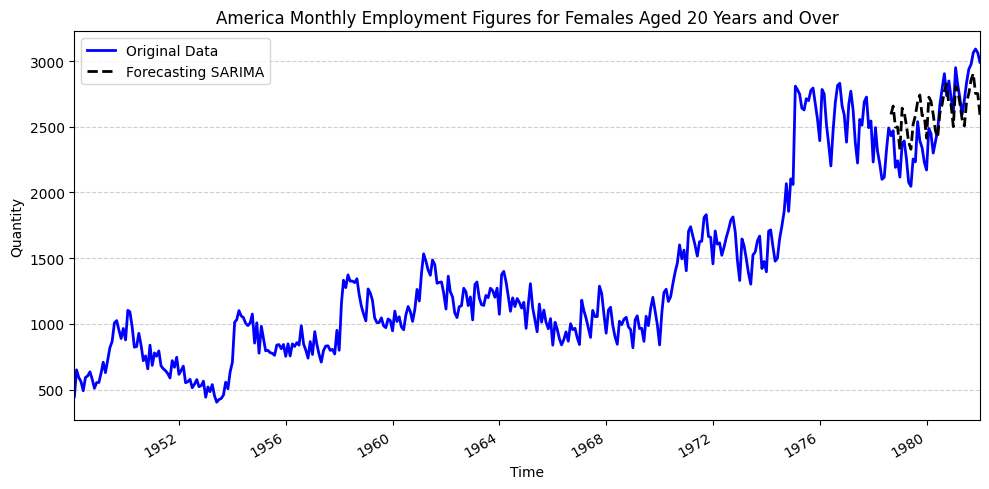

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(amef, color='blue', label='Original Data', linewidth=2)
ax.plot(test_zone['forecast_amef'], linestyle='--', color='black', label='Forecasting SARIMA', linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel('Quantity')
ax.set_title('America Monthly Employment Figures for Females Aged 20 Years and Over')
ax.set_xlim(pd.to_datetime('1948-01-31'), pd.to_datetime('1981-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

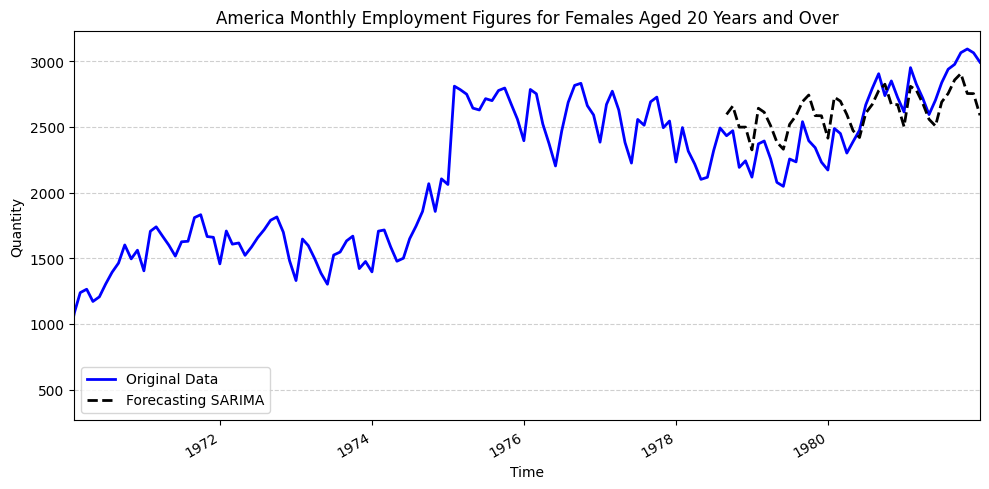

In [29]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(amef, color='blue', label='Original Data', linewidth=2)
ax.plot(test_zone['forecast_amef'], linestyle='--', color='black', label='Forecasting SARIMA', linewidth=2)
#ax.plot(test_zone['correction'], linestyle='--', color='orange', label='Forecasting w/ Correction', linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel('Quantity')
ax.set_title('America Monthly Employment Figures for Females Aged 20 Years and Over')
ax.set_xlim(pd.to_datetime('1970-01-31'), pd.to_datetime('1981-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(loc=3)

fig.autofmt_xdate()
plt.tight_layout()

In [30]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = (100 * abs(test_zone['original data'] - test_zone['forecast_amef']) / test_zone['original data']).mean()
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 8.10%


#### Now, with more test data

In [32]:
# Split the data into training and test sets (98% for training, 2% for testing)
train_size = int(len(amef) * 0.98)
train_data, test_data = amef[:train_size], amef[train_size:]

print(len(train_data))
print(len(test_data))

399
9


In [33]:
# Fit the auto_arima model (from pmdarima import auto_arima)
model_amef = auto_arima(train_data, seasonal=True, m=12, trace=True, stepwise=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=4706.457, Time=2.68 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5007.710, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4806.772, Time=1.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=4888.486, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5006.477, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=4891.149, Time=2.42 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=4802.392, Time=2.79 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=7.40 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=inf, Time=7.64 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=5.51 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=4762.504, Time=6.30 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=9.59 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=4705.535, Time=2.09 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=i

In [34]:
SARIMA_model_fit = sm.tsa.SARIMAX(train_data, order = (2,1,0), seasonal_order=(1,0,1,12)).fit()

In [35]:
# Create an empty dataframe
test_zone = pd.DataFrame()

# Original Data created based on the end of the original dataset
test_zone['original data'] = amef.iloc[-len(test_data):]

test_zone.head()

,original data
1981-04-30,2593
1981-05-31,2703
1981-06-30,2836
1981-07-31,2938
1981-08-31,2975


In [36]:
# Forecast for the  data (amef)
forecast_amef = SARIMA_model_fit.forecast(steps=len(test_data))

test_zone['forecast_amef'] = forecast_amef
test_zone['difference'] = test_zone['forecast_amef'] - test_zone['original data']

test_zone.head()

,original data,forecast_amef,difference
1981-04-30,2593,2620.573207,27.573207
1981-05-31,2703,2605.593906,-97.406094
1981-06-30,2836,2788.858074,-47.141926
1981-07-31,2938,2850.624315,-87.375685
1981-08-31,2975,2966.268484,-8.731516


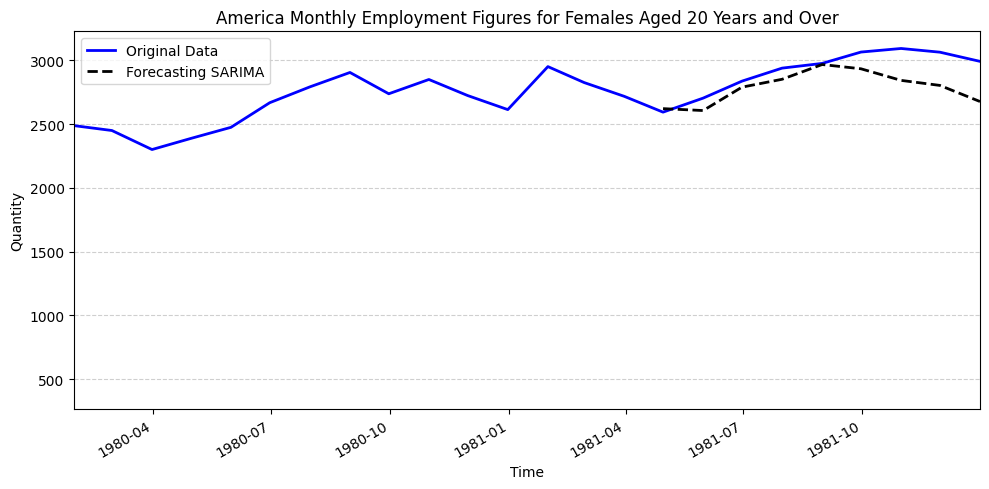

In [37]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(amef, color='blue', label='Original Data', linewidth=2)
ax.plot(test_zone['forecast_amef'], linestyle='--', color='black', label='Forecasting SARIMA', linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel('Quantity')
ax.set_title('America Monthly Employment Figures for Females Aged 20 Years and Over')
ax.set_xlim(pd.to_datetime('1980-01-31'), pd.to_datetime('1981-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

In [38]:
# Calculate Mean Absolute Percentage Error (MAPE)
mape = (100 * abs(test_zone['original data'] - test_zone['forecast_amef']) / test_zone['original data']).mean()
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Absolute Percentage Error (MAPE): 4.55%


### Respectively use models SARIMA(2, 1, 0)(0, 1, 0)4 and SARIMA(1, 1, 1)(0, 1, 0)4 to fit the logged series (viz., lx) in Example 5.4, and then compare themwith the resulting model in Example 5.4.

In [40]:
x = pd.read_csv(dtapath + 'gdpquarterlychina1992.1-2017.4.csv', header = 0)

dates = pd.date_range(start = '1992', periods = len(x), freq = 'Q')

x.index = dates
x = pd.Series(x['GDP'])

x

1992-03-31      5234.8
1992-06-30      6536.8
1992-09-30      7122.5
1992-12-31      8174.3
1993-03-31      6803.1
                ...   
2016-12-31    211151.4
2017-03-31    180385.3
2017-06-30    200558.7
2017-09-30    211595.5
2017-12-31    234582.2
Freq: QE-DEC, Name: GDP, Length: 104, dtype: float64

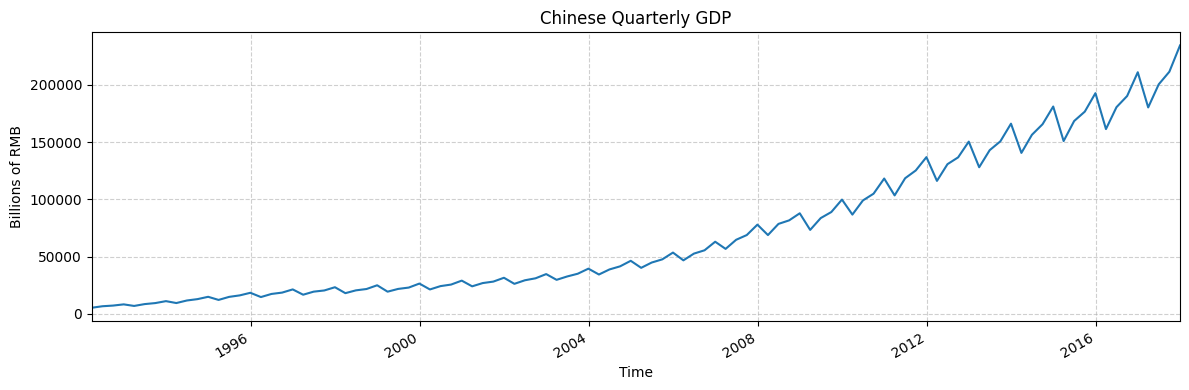

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x)
ax.set_xlabel('Time')
ax.set_ylabel('Billions of RMB')
ax.set_title('Chinese Quarterly GDP')
ax.set_xlim(pd.to_datetime('1992-03-31'), pd.to_datetime('2017-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  
ax.grid(axis='x', linestyle='--', alpha=0.6) 

fig.autofmt_xdate()
plt.tight_layout()

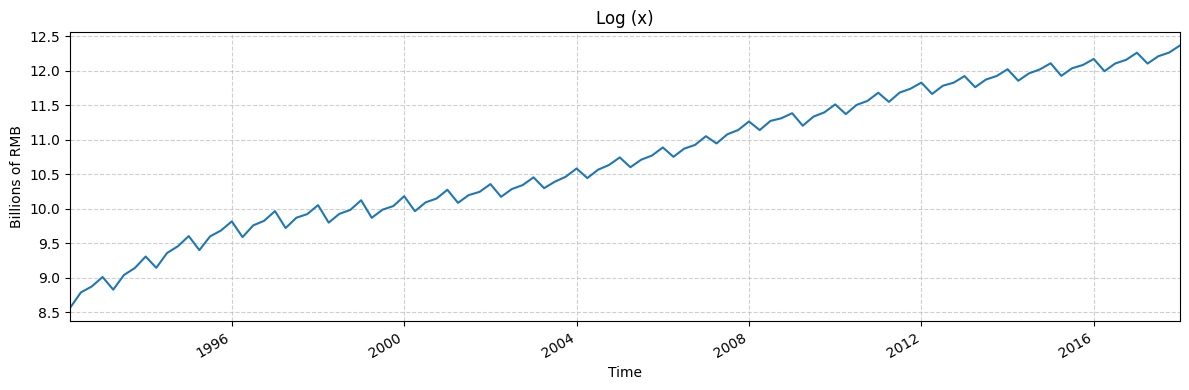

In [42]:
lx = np.log(x)

fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(lx)
ax.set_xlabel('Time')
ax.set_ylabel('Billions of RMB')
ax.set_title('Log (x)')
ax.set_xlim(pd.to_datetime('1992-03-31'), pd.to_datetime('2017-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  
ax.grid(axis='x', linestyle='--', alpha=0.6) 

fig.autofmt_xdate()
plt.tight_layout()

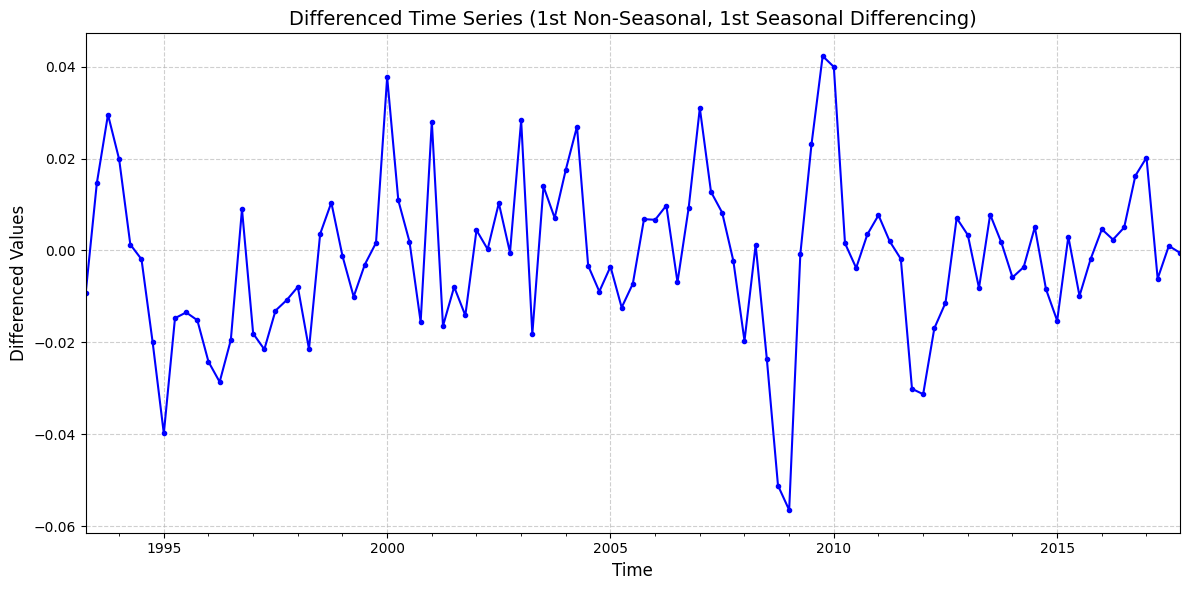

In [43]:
# Perform differencing
dDlx = sm.tsa.statespace.tools.diff(lx, k_diff=1, k_seasonal_diff=1, seasonal_periods=4)

# Plot the differenced series
plt.figure(figsize=(12, 6))  
dDlx.plot(marker='o', ms=3, linestyle='-', color='b', label='Differenced Data') 

# Add labels and title
plt.title('Differenced Time Series (1st Non-Seasonal, 1st Seasonal Differencing)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Differenced Values', fontsize=12)

# Grid
plt.grid(True, linestyle='--', alpha=0.6)

# Adjust layout and Display
plt.tight_layout()
plt.show()

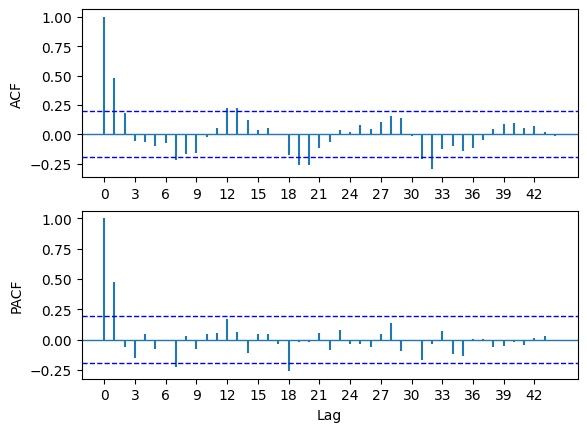

In [44]:
acf_pacf_fig(dDlx, both = True, lag = 44)

In [45]:
# Perform the KPSS test without specifying 'maxlag'
kpss_stat, p_value, lags, critical_values = sm.tsa.kpss(dDlx, regression='c')

# Output the results
print(f"KPSS Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical Values: {critical_values}")

KPSS Statistic: 0.10298546572401576
P-value: 0.1
Lags used: 4
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [46]:
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
kpss_stat, p_value, lags, critical_values = kpss(dDlx, regression='c', nlags=50)

# Output the results
print(f"KPSS Test Statistic: {kpss_stat}")
print(f"P-value: {p_value}")
print(f"Lags used: {lags}")
print(f"Critical values: {critical_values}")
print()

# Interpretation
if p_value < 0.05:
    print("p-value < 0.05; Ha: series is Non-stationary")
else:
    print("p-value > 0.05; H0: series is Stationary")

KPSS Test Statistic: 0.30929523130411846
P-value: 0.1
Lags used: 50
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}

p-value > 0.05; H0: series is Stationary


In [47]:
# Define the SARIMA model with specific parameters
sarima0200 = sm.tsa.SARIMAX(lx,                           # The input time series data (lx)
                            order=(0, 1, 2),              # Non-seasonal ARMA order (p=0, d=1, q=2)
                            seasonal_order=(0, 1, 0, 4))  # Seasonal ARMA order (P=0, D=1, Q=0, s=4)

# Fit the SARIMA model to the data
sarimaRes0200 = sarima0200.fit()  

# Print the summary of the model fit
print(sarimaRes0200.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                GDP   No. Observations:                  104
Model:             SARIMAX(0, 1, 2)x(0, 1, [], 4)   Log Likelihood                 274.805
Date:                            Fri, 07 Mar 2025   AIC                           -543.610
Time:                                    14:17:23   BIC                           -535.824
Sample:                                03-31-1992   HQIC                          -540.460
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4940      0.080      6.140      0.000       0.336       0.652
ma.L2          0.2688      0.102   

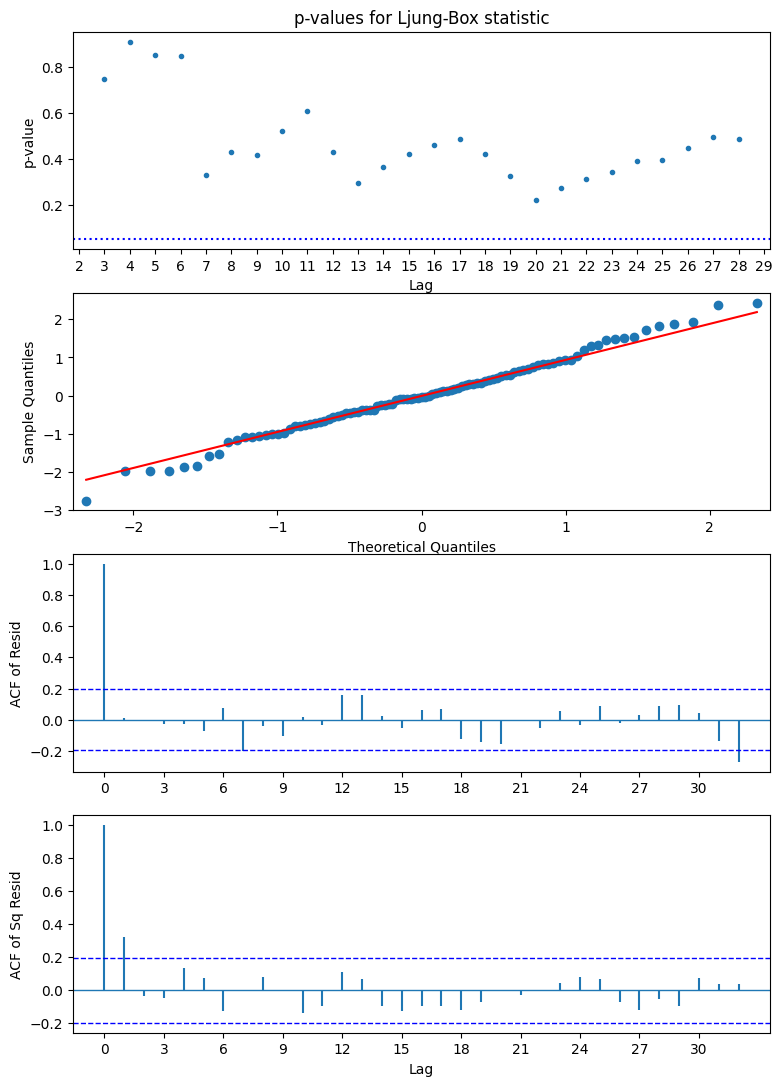

In [48]:
# Extract the residuals from the fitted SARIMA model, starting from the 6th value
resid0200 = sarimaRes0200.resid[5:]  # Excluding the first 5 values for stability

# Plot the residual diagnostics for the residuals
plot_ResidDiag(resid0200,            # Pass the residuals for diagnostic plotting
               noestimatedcoef=2,    # Remove the first two estimated coefficients from the plot for clarity
               nolags=28,            # Limit the number of lags to 28 for the ACF/PACF plots
               lag=32)               # Set the maximum number of lags for the residual diagnostic plots

In [49]:
fore0200 = sarimaRes0200.predict(start = '2018-03-31', end = '2018-12-31')
fore = np.exp(fore0200)
fore

2018-03-31    200804.519733
2018-06-30    223319.098204
2018-09-30    235608.409129
2018-12-31    261203.754107
Freq: QE-DEC, Name: predicted_mean, dtype: float64

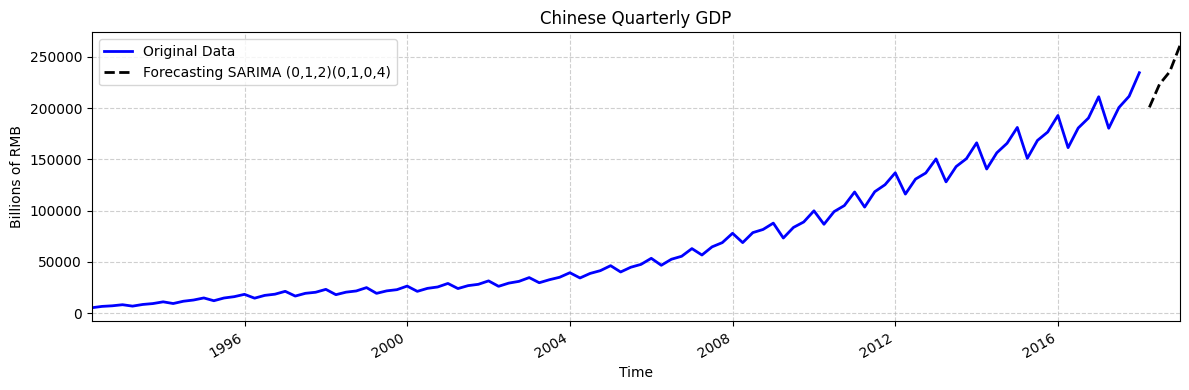

In [50]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, color='blue', label='Original Data', linewidth=2)
ax.plot(fore, linestyle='--', color='black', label='Forecasting SARIMA (0,1,2)(0,1,0,4)', linewidth=2)
ax.set_xlabel('Time')
ax.set_ylabel('Billions of RMB')
ax.set_title('Chinese Quarterly GDP')
ax.set_xlim(pd.to_datetime('1992-03-31'), pd.to_datetime('2018-12-31'))
ax.grid(axis='y', linestyle='--', alpha=0.6)  
ax.grid(axis='x', linestyle='--', alpha=0.6) 
ax.legend()

fig.autofmt_xdate()
plt.tight_layout()

#### Exercise

In [52]:
# Define the SARIMA (2, 1, 0)(0, 1, 0)4
sarima210 = sm.tsa.SARIMAX(lx,                            # The input time series data (lx)
                            order=(2, 1, 0),              # Non-seasonal ARMA order (p, d, q)
                            seasonal_order=(0, 1, 0, 4))  # Seasonal ARMA order (P, D, Q, s)

# Fit the SARIMA model to the data
sarimaRes210 = sarima210.fit() 

# Extract the residuals from the fitted SARIMA model, starting from the 6th value
resid210 = sarimaRes210.resid[5:]                         # Excluding the first 5 values for stability

# Predictions for SARIMA (2, 1, 0)(0, 1, 0)4
fore210 = sarimaRes210.predict(start = '2018-03-31', end = '2018-12-31')
fore210010 = np.exp(fore210)
fore210010

2018-03-31    200337.021717
2018-06-30    222711.498312
2018-09-30    234955.597827
2018-12-31    260475.451626
Freq: QE-DEC, Name: predicted_mean, dtype: float64

In [53]:
# Define the SARIMA (1, 1, 1)(0, 1, 0)4
sarima111 = sm.tsa.SARIMAX(lx,                            # The input time series data (lx)
                            order=(1, 1, 1),              # Non-seasonal ARMA order (p, d, q)
                            seasonal_order=(0, 1, 0, 4))  # Seasonal ARMA order (P, D, Q, s)

# Fit the SARIMA model to the data
sarimaRes111 = sarima111.fit() 

# Extract the residuals from the fitted SARIMA model, starting from the 6th value
resid111 = sarimaRes111.resid[5:]                         # Excluding the first 5 values for stability

# Predictions for (1, 1, 1)(0, 1, 0)4
fore111 = sarimaRes111.predict(start = '2018-03-31', end = '2018-12-31')
fore1110104 = np.exp(fore111)
fore1110104

2018-03-31    200345.134337
2018-06-30    222723.257861
2018-09-30    234967.190341
2018-12-31    260486.816972
Freq: QE-DEC, Name: predicted_mean, dtype: float64

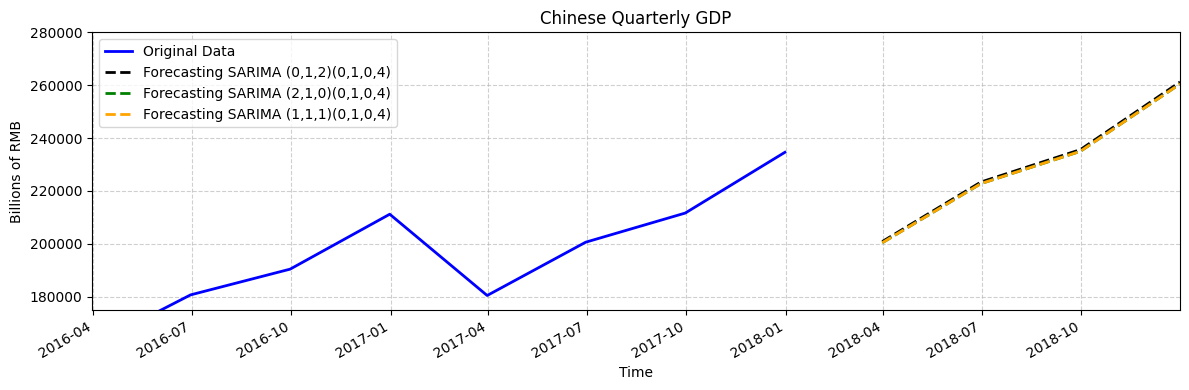

In [54]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(x, color='blue', label='Original Data', linewidth=2)
ax.plot(fore, linestyle='--', color='black', label='Forecasting SARIMA (0,1,2)(0,1,0,4)', linewidth=2)
ax.plot(fore210010, linestyle='--', color='green', label='Forecasting SARIMA (2,1,0)(0,1,0,4)', linewidth=2)
ax.plot(fore1110104, linestyle='--', color='orange', label='Forecasting SARIMA (1,1,1)(0,1,0,4)', linewidth=2)

ax.set_xlabel('Time')
ax.set_ylabel('Billions of RMB')
ax.set_title('Chinese Quarterly GDP')
ax.set_xlim(pd.to_datetime('2016-03-31'), pd.to_datetime('2018-12-31'))
ax.set_ylim(175000, 280000)
ax.grid(axis='y', linestyle='--', alpha=0.6)  
ax.grid(axis='x', linestyle='--', alpha=0.6) 
ax.legend(loc=2)

fig.autofmt_xdate()
plt.tight_layout()

### Extract a subseries from Jan. 1970 to Dec. 2007 from the Southern Hemisphere temperature volatility data series in Example 3.1. And then analyze the subseries using the methods in Example 5.6.

In [56]:
# Southern Hemisphere Temperature Volatility 

temp = pd.read_csv(dtapath + 'Southtemperature.txt', header = None, sep='\s+')

temts = pd.concat([temp.loc[0], temp.loc[1]] ,ignore_index='true')

for i in range(2,158):
    temts=pd.concat([temts,temp.loc[i]],ignore_index = 'true')

dates=pd.date_range('1850', periods = len(temts), freq ='M')
temts.index=dates

temts

1850-01-31   -0.625
1850-02-28   -0.598
1850-03-31   -0.841
1850-04-30   -0.632
1850-05-31   -0.326
              ...  
2007-08-31    0.139
2007-09-30    0.296
2007-10-31    0.190
2007-11-30    0.080
2007-12-31   -0.011
Freq: ME, Length: 1896, dtype: float64

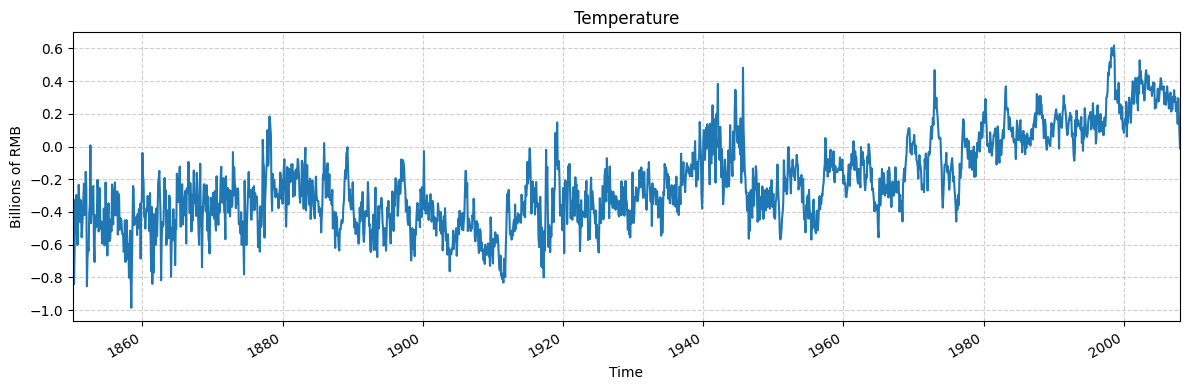

In [57]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(temts)
ax.set_xlabel('Time')
ax.set_ylabel('Billions of RMB')
ax.set_title('Temperature')
ax.set_xlim(pd.to_datetime('1850-01-31'), pd.to_datetime('2007-12-31'))
ax.grid(True, linestyle='--', alpha=0.6)

fig.autofmt_xdate()
plt.tight_layout()

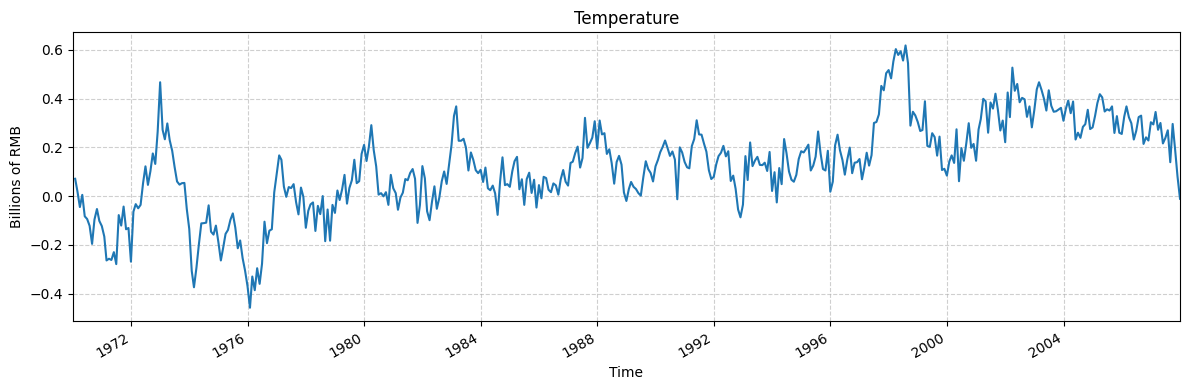

In [58]:
# Filter data from Jan 1970 to Dec 2007
temts_filtered = temts.loc['1970-01-01':'2007-12-31']  

# Plot
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(temts_filtered)
ax.set_xlabel('Time')
ax.set_ylabel('Billions of RMB')
ax.set_title('Temperature')
ax.set_xlim(pd.to_datetime('1970-01-01'), pd.to_datetime('2007-12-31'))
ax.grid(True, linestyle='--', alpha=0.6)

fig.autofmt_xdate()
plt.tight_layout()

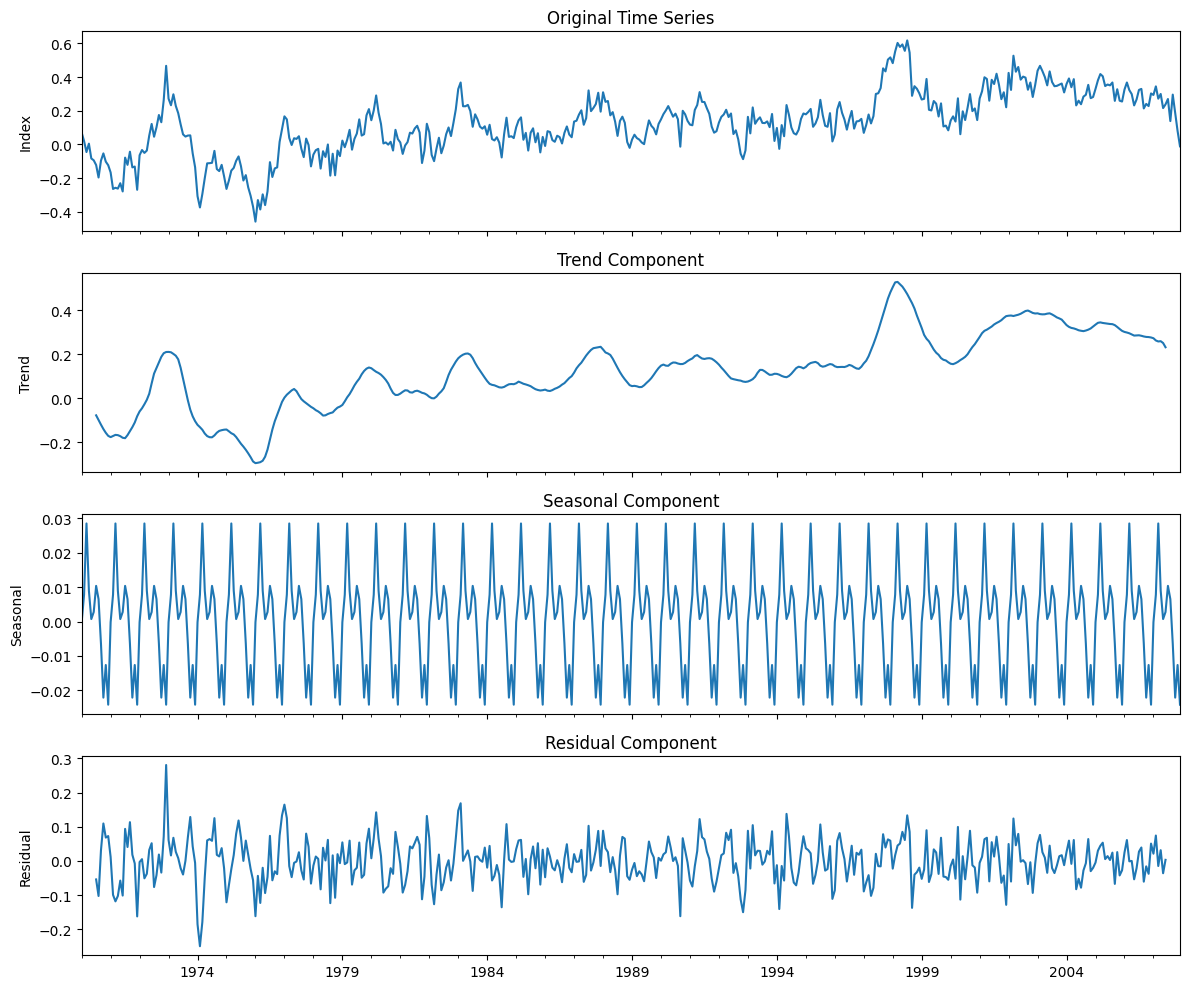

In [59]:
# Perform seasonal decomposition
temfil_decom = seasonal_decompose(temts_filtered, model='aditive')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

temfil_decom.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Index')

temfil_decom.trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

temfil_decom.seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

temfil_decom.resid.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [60]:
# Fit the auto_arima model (from pmdarima import auto_arima)
model_temts = auto_arima(temts_filtered,         # Data
                        seasonal=True,           # Search for a seasonal model
                        m=12,                    # Monthly data with patterns repeating every year 
                        trace=True,              # Enables verbose output during the grid search
                        stepwise=True,           # Fewer combinations than a full grid search
                        suppress_warnings=True)  # We don't want to see output from convergence warnings

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-1070.151, Time=2.31 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1040.446, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1071.601, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1073.389, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1042.444, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1075.308, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-1073.397, Time=0.52 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-1073.823, Time=1.45 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-1073.383, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=-1073.349, Time=0.28 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=-1073.320, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-1073.096, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[12]             : AIC=-1077.308, Time=0.12 sec
 ARIMA(0,1,1)(1,0,0)[12]             : AIC=-1075.397, Time=0.20 sec
 ARIM

In [61]:
# Define the SARIMA model with specific parameters
sarima011 = sm.tsa.SARIMAX(temts_filtered,                 # The input time series data (lx)
                            order=(0, 1, 1),               # Non-seasonal ARMA order (p,d,q)
                            seasonal_order=(0, 0, 0, 12))  # Seasonal ARMA order (P,D,Q,s)

# Fit the SARIMA model to the data
sarimafit011 = sarima011.fit()  

# Print the summary of the model fit
print(sarimafit011.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  456
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 540.654
Date:                Fri, 07 Mar 2025   AIC                          -1077.308
Time:                        14:17:37   BIC                          -1069.067
Sample:                    01-31-1970   HQIC                         -1074.062
                         - 12-31-2007                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2945      0.043     -6.921      0.000      -0.378      -0.211
sigma2         0.0054      0.000     16.049      0.000       0.005       0.006
Ljung-Box (L1) (Q):                   0.00   Jarque-

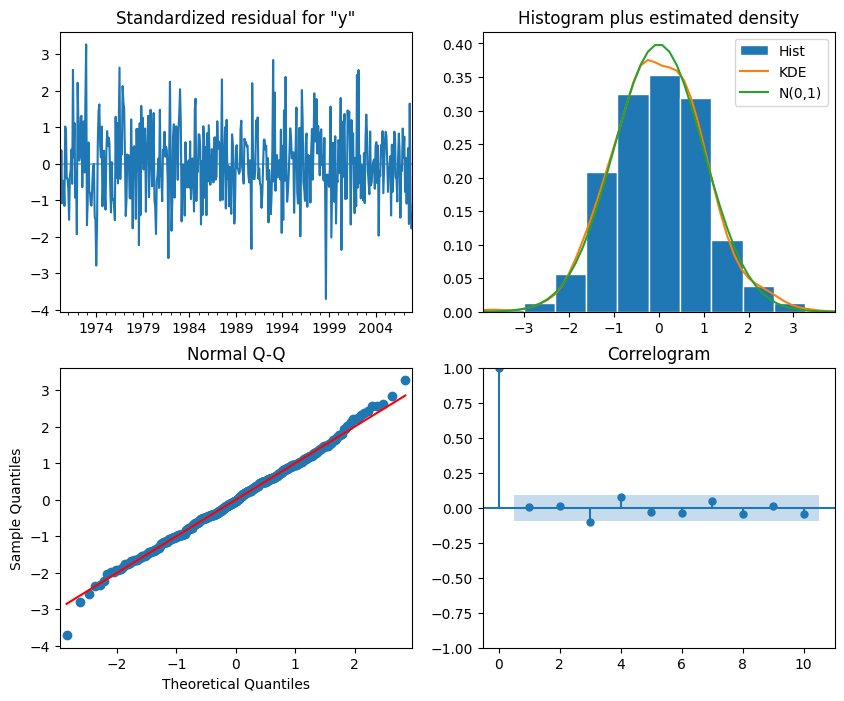

In [62]:
sarimafit011.plot_diagnostics(figsize=(10,8));

In [63]:
# Extract the residuals (errors) from the fitted model
residuals1 = sarimafit011.resid 

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals1 = acorr_ljungbox(residuals1, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals1['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals1

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.000929,0.975679
2,0.072404,0.964445
3,4.754790,0.190659
4,7.238171,0.123825
5,7.706934,0.173144
6,8.378320,0.211676
7,9.364711,0.227521
8,10.327071,0.242816
9,10.464506,0.314205
10,11.550036,0.316298
